# Analysis

In der Phase des Prototyping haben wir vom Datenset erst die ersten 1'000 Zeilen verwendet. Nach den Erkenntnissen aus dem Prototyping laden wir nun die vollständigen Daten auf unseren Cluster.

Der verwendete Datensatz verfügt über zwei Files. Das grosse File steht als CSV-File zur Verfügung, das zweite (Carriers) wird als TXT-File hochgeladen.
Beim Prototyping hat sich gezeigt, dass die Datenmenge beim Speichern als Parquet signifikant reduziert hat. Somit können wir die Performance der Berechnungen verbessern, wenn wir unseren vollständigen Datensatz ebenfalls als Parquet speichern.

### Weshalb Parquet?

Unser Datensatz verfügt über ca. 12GB Daten. Da Parquet auf Geschwindigkeit und Komprimierung optimiert ist, eigent sich dieses Format für solch grosse Datenmengen. Auch verfügt unser Datensatz über 29 Spalten. Bei all unseren Fragestellungen benötigen wir jedoch nur immer einen Bruchteil der Spalten, weshalb das Auslesen der Daten (was immer Zeilenweise geschieht) schneller ist mit Parquet.
Auch haben wir viele identische "NA" Einträge, welche durch die Kompirimierung die Datenmenge signifikant reduziert.

## Bereitstellen der vollständigen Daten

Das Verzeichnis ist bereits aus dem Prototypin vorhanden. Wir werwenden  /airline-data.

In [ ]:
!hdfs dfs -ls /airline-data

In [ ]:
# !hdfs dfs -put ~/BDLC-Project-G01/Dataset/airline.csv /airline-data
# !hdfs dfs -put ~/BDLC-Project-G01/Dataset/carriers.txt /airline-data

In [2]:
!hdfs dfs -ls /airline-data

Found 2 items
drwxr-xr-x   - cluster supergroup          0 2022-05-12 12:35 /airline-data/airline.parquet
-rw-r--r--   2 cluster supergroup      43758 2022-05-12 12:29 /airline-data/carriers.txt


### 1. Daten als Parquet speichern

In [1]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName('ConvertToParquet').getOrCreate()

In [ ]:
!hdfs dfs -ls /airline-data/

### a) Parquet File schreiben

In [ ]:
!hdfs dfs -cat /airline-data/airline.csv | head

In [ ]:
spark.read.csv('/airline-data/airline.csv', header=True).repartition(55).write.parquet('/airline-data/airline.parquet')

In [171]:
!hdfs dfs -ls /airline-data/

Found 2 items
drwxr-xr-x   - cluster supergroup          0 2022-05-12 12:35 /airline-data/airline.parquet
drwxr-xr-x   - cluster supergroup          0 2022-05-22 14:41 /airline-data/carriers.parquet


In [ ]:
!hdfs dfs -cat /airline-data/carriers.txt | head

In [22]:
spark.read.csv('/airline-data/carriers.txt', header=True).repartition(55).write.parquet('/airline-data/carriers.parquet')

In [23]:
!hdfs dfs -ls /airline-data/

Found 3 items
drwxr-xr-x   - cluster supergroup          0 2022-05-12 12:35 /airline-data/airline.parquet
drwxr-xr-x   - cluster supergroup          0 2022-05-22 14:41 /airline-data/carriers.parquet
-rw-r--r--   2 cluster supergroup      43758 2022-05-12 12:29 /airline-data/carriers.txt


### b) Raw File löschen

In [ ]:
!hdfs dfs -rm /airline-data/airline.csv

In [24]:
!hdfs dfs -rm /airline-data/carriers.txt

Deleted /airline-data/carriers.txt


In [173]:
!hdfs dfs -ls /airline-data/

Found 2 items
drwxr-xr-x   - cluster supergroup          0 2022-05-12 12:35 /airline-data/airline.parquet
drwxr-xr-x   - cluster supergroup          0 2022-05-22 14:41 /airline-data/carriers.parquet


### c) Spark-Session stoppen

In [ ]:
# Die SPARK-Sesseion Con
spark.stop()

## Datensatz in Tabelle schreiben

In [ ]:
#!hdfs dfs -mkdir /user/spark/warehouse

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession \
    .builder \
    .appName("SQL with SPARK") \
    .enableHiveSupport() \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-27 16:16:19,736 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


"spark"  ist nun eine existierende SparkSession (siehe: http://bdlc-05.el.eee.intern:8080/ )

In dieser erstellen wir nun ein Dataframe, welches innerhalb dieses Spark-Session verfügbar ist:

### Airline-Daten

In [5]:
df_air = spark.read.parquet("/airline-data/airline.parquet")

In [6]:
df_air.show(n=10)

2022-05-27 07:34:03,118 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+-----+--------+------+-------------+-------+------+-------+-------------+------------+----+
|ActualElapsedTime|AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|Month|NASDelay|Origin|SecurityDelay|TailNum|TaxiIn|TaxiOut|UniqueCarrier|WeatherDelay|Year|
+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+-----+--------+------+-------------+-------+------+-------+-------------+------------+----+
|              120|     98|       4|   1214|      1210|       915|           115|            n

### Carrier-Daten

In [7]:
df_carr = spark.read.parquet("/airline-data/carriers.parquet")

In [8]:
df_carr.show(n=10, truncate=False)
#verwendete Option Truncate = damit der Content der Description vollständig aufgeführt wird.

+----+------------------------------------------------+
|Code|Description                                     |
+----+------------------------------------------------+
|AAA |Associated Aviation Act.                        |
|RIA |Trump Air                                       |
|LB  |Lloyd Aereo Boliviano S. A.                     |
|6R  |Aerounion Aerotransporte de Carga Union SA de CV|
|4H  |Belize Trans Air                                |
|MEA |Manhattan Express                               |
|TR  |Transbrasil S.A.                                |
|KL  |Klm Royal Dutch Airlines                        |
|CRN |Crown Aviaiton Inc.                             |
|CHD |Chandler Flyer                                  |
+----+------------------------------------------------+
only showing top 10 rows



## Plausibilisierung des DataFrames

Vor der Bearbeitung der Fragestellungen muss der Datensatz zuerst noch plausibilisiert werden. Hierfür zählen wir die Datensätze:

### Airline

In [9]:
df_air.createOrReplaceTempView("df_air")

In [10]:
anzahlZeilen = spark.sql("SELECT COUNT(FlightNum) FROM df_air")

In [11]:
anzahlZeilen.show()

+----------------+
|count(FlightNum)|
+----------------+
|       123534969|
+----------------+



Die Auswertung zeigt, dass im Datensatz 123.5 Mio Flugzeilen enthalten sind. Dies haben wir über den Datensatz lokal auf dem Laptop verifiziert (:-)= würde natürlich bei einem echten Big-Data-Problem nicht funktionieren.

In [62]:
anzahlFluggesellschaften = spark.sql("SELECT UniqueCarrier FROM df_air GROUP BY UniqueCarrier")
anzahlFluggesellschaften.count()

29

In den Flugdaten sind lediglich von 29 Fluggesellschaften die Flugdaten enthalten. Dies zur Plausibilisierung der Outputs der kommenden Fragestellungen.

### Carriers

In [ ]:
df_carr.createOrReplaceTempView("df_carr")

In [16]:
anzahlFluggesellschaften = spark.sql("SELECT COUNT(Code) FROM df_carr")

In [17]:
anzahlFluggesellschaften.show()

+-----------+
|count(Code)|
+-----------+
|       1491|
+-----------+



Gemäss den Ausführungen auf Kaggle sind es 1'491 Datensätze. Somit ist der Datensatz korrekt im SPARK vorhanden.

In [57]:
df_carr.sort("Code").show(truncate=False)

+----+--------------------------------------------+
|Code|Description                                 |
+----+--------------------------------------------+
|02Q |Titan Airways                               |
|04Q |Tradewind Aviation                          |
|05Q |Comlux Aviation, AG                         |
|06Q |Master Top Linhas Aereas Ltd.               |
|07Q |Flair Airlines Ltd.                         |
|09Q |Swift Air, LLC                              |
|0BQ |DCA                                         |
|0CQ |ACM AIR CHARTER GmbH                        |
|0FQ |Maine Aviation Aircraft Charter, LLC        |
|0GQ |Inter Island Airways, d/b/a Inter Island Air|
|0HQ |Polar Airlines de Mexico d/b/a Nova Air     |
|0J  |JetClub AG                                  |
|0JQ |Vision Airlines                             |
|0KQ |Mokulele Flight Services, Inc.              |
|0LQ |Metropix UK, LLP.                           |
|0MQ |Multi-Aero, Inc. d/b/a Air Choice One       |
|0Q  |Flying

# Fragestellungen

Die nachfolgenden Abfragen können somit nun in der SparkSession und auf dem DataFrame "df" ausgewertet werden.

### Fluggesellschaften (UniqueCarrier)

#### Welche Fluggesellschaften hatte am meisten Verspätungen?

In [18]:
import pyspark.sql.functions as func

flug = spark.sql("""
SELECT Description, UniqueCarrier, SUM(ArrDelay)/60/24 as DelayInDays 
FROM df_air JOIN df_carr ON df_air.UniqueCarrier = df_carr.Code 
GROUP BY Description, UniqueCarrier 
ORDER BY DelayInDays DESC""")
flug2 = flug.withColumn("DelayInDays", func.round(flug["DelayInDays"],0))
#Um die Funktion round zu verwenden, wurden die functions von pyspark.sql importiert

Für die nachfolgenden Plots wurde die Library matplotlib installiert.

In [19]:
#pip install matplotlib

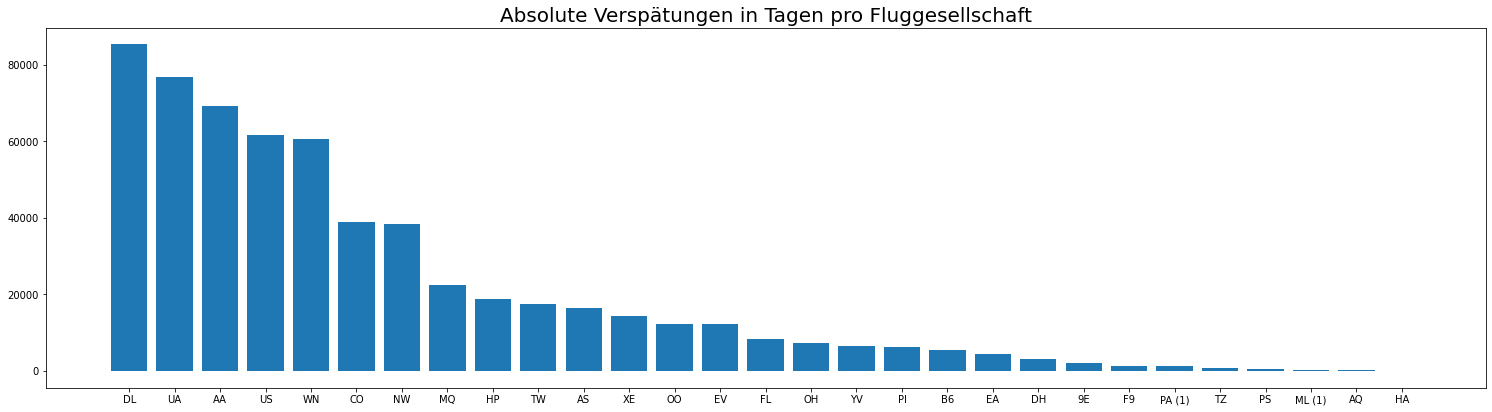

+-----------------------------------------------------------------------------------+-------------+-----------+
|Description                                                                        |UniqueCarrier|DelayInDays|
+-----------------------------------------------------------------------------------+-------------+-----------+
|Delta Air Lines Inc.                                                               |DL           |85315.0    |
|United Air Lines Inc.                                                              |UA           |76865.0    |
|American Airlines Inc.                                                             |AA           |69125.0    |
|US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)|US           |61499.0    |
|Southwest Airlines Co.                                                             |WN           |60555.0    |
|Continental Air Lines Inc.                                                         |CO           |38772

In [66]:
import matplotlib.pyplot as plt
import pandas

dfPlot2 = flug2

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
x=dfPlot.toPandas()["UniqueCarrier"].values.tolist()
y=dfPlot.toPandas()["DelayInDays"].values.tolist()
ax.set_title('Absolute Verspätungen in Tagen pro Fluggesellschaft', fontsize=20)
ax.bar(x,y)
plt.show()

dfPlot2.show(50, truncate=False)

Absolut betrachtet hat die Fluggesellschaft DL (Delta Air Lines) insgesamt die längsten Verspätungen mit insgesamt 85'315 Tagen. Über die Qualität darf hierauf jedoch noch keine Aussage getroffen werden, denn wer mehr fliegt, hat evtl. auch mehr Verspätungen. Deshalb ist die relative Verspätung in der nächsten Frage abgehandelt.

#### Welche Fluggesellschaften haben prozentual (+/-) die grössten Abweichungen der geplanten Flugzeit zur effektiven Flugzeit (geplante Abflugzeit bis effektive Ankunftszeit)?

In [21]:
import pyspark.sql.functions as func
flug3 = spark.sql("""
SELECT Description, UniqueCarrier, SUM(ArrDelay)/SUM(AirTime)*100 as DelayPercentage 
FROM df_air JOIN df_carr ON df_air.UniqueCarrier = df_carr.Code 
GROUP BY Description, UniqueCarrier
ORDER BY DelayPercentage DESC""")
flug4 = flug3.withColumn("DelayPercentage", func.round(flug3["DelayPercentage"],3))

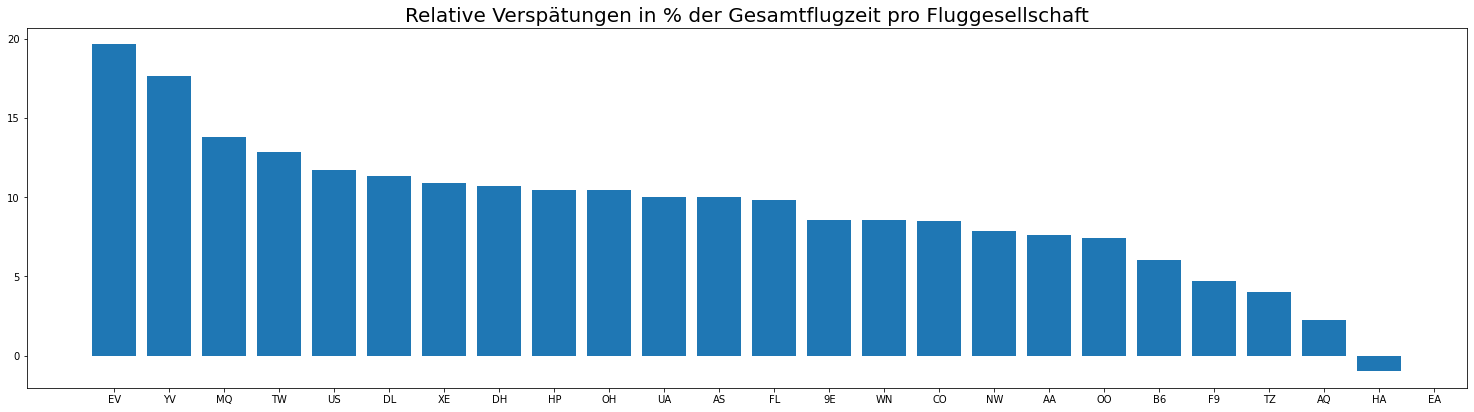

+-----------------------------------------------------------------------------------+-------------+---------------+
|Description                                                                        |UniqueCarrier|DelayPercentage|
+-----------------------------------------------------------------------------------+-------------+---------------+
|Atlantic Southeast Airlines                                                        |EV           |19.651         |
|Mesa Airlines Inc.                                                                 |YV           |17.612         |
|American Eagle Airlines Inc.                                                       |MQ           |13.763         |
|Trans World Airways LLC                                                            |TW           |12.848         |
|US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)|US           |11.705         |
|Delta Air Lines Inc.                                                   

In [68]:
import matplotlib.pyplot as plt
import pandas

dfPlot4 = flug4

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
x=dfPlot.toPandas()["UniqueCarrier"].values.tolist()
y=dfPlot.toPandas()["DelayPercentage"].values.tolist()
ax.set_title('Relative Verspätungen in % der Gesamtflugzeit pro Fluggesellschaft', fontsize=20)
ax.bar(x,y)
plt.show()

dfPlot4.show(50,truncate=False)

Relativ betrachtet hat die Fluggesellschaft EV (Atlantic Southeast Airlines) die meisten Verspätungen im Verhältnis zur absoluten Flugzeit. Nämlich 19.6% der Gesamten Flugzeit. Zu erwähnen ist, dass die EV bei einer lediglich absoluten Betrachtung "nur" an 14. Stelle wäre, weshalb das relative Verhältnis mit der gesamten Flugzeit relevant ist, um eine Qualitäts-Aussage über die Fluggesellschaft zu fällen.
Es fällt auf, dass die HA insgesamt früher landet als geplant (Sum of ArrDelay ist im Minus), weshalb es mit -1% am zuverlässigsten ist (oder einfach sehr langsam eingeplant :) ).

Zusätzlich fällt auf, dass nach HA noch bei 5  Fluggesellschaften die AirTime nicht im Datensatz enthalten sind (bzw. mit NA geliefert). Diese werden in den Auswertungen nicht gerechnet und sind somit nicht einbezogen. Somit ist der Output von 24 Fluggesellschaften in der Grafik korrekt.

In [46]:
#Nachweis, dass für die "null" Fluggesellschaften keine AirTime-Angaben vorliegen (bei ASC kämen zuerst die NA, anschliessend die Values):

controll = spark.sql("""
SELECT UniqueCarrier, SUM(AirTime) FROM df_air LEFT OUTER JOIN df_carr ON df_air.UniqueCarrier = df_carr.Code 
GROUP BY UniqueCarrier
HAVING SUM(AirTime) IS NULL
""")
controll.show()

+-------------+------------+
|UniqueCarrier|sum(AirTime)|
+-------------+------------+
|           EA|        null|
|           PI|        null|
|           PS|        null|
|       ML (1)|        null|
|       PA (1)|        null|
+-------------+------------+



#### Bei welchen 5 Fluggesellschaften werden die meisten Flüge gestrichen?

In [116]:
flug5 = spark.sql("""
SELECT Description, UniqueCarrier, CAST(SUM(Cancelled) AS integer) AS CancelledSum, COUNT(FlightNum) AS TotalFluege, 
    CAST(SUM(Cancelled)/COUNT(Cancelled)*100 AS decimal (9,2)) AS Canc_Percentage
FROM df_air JOIN df_carr ON df_air.UniqueCarrier = df_carr.Code 
GROUP BY Description, UniqueCarrier 
ORDER BY Canc_Percentage DESC""")
flug5.show(5,truncate=False)

+----------------------------+-------------+------------+-----------+---------------+
|Description                 |UniqueCarrier|CancelledSum|TotalFluege|Canc_Percentage|
+----------------------------+-------------+------------+-----------+---------------+
|American Eagle Airlines Inc.|MQ           |157478      |3954895    |3.98           |
|Mesa Airlines Inc.          |YV           |30050       |854056     |3.52           |
|Comair Inc.                 |OH           |47174       |1464176    |3.22           |
|Independence Air            |DH           |22176       |693047     |3.20           |
|Eastern Air Lines Inc.      |EA           |28702       |919785     |3.12           |
+----------------------------+-------------+------------+-----------+---------------+
only showing top 5 rows



Auch bei dieser Frage ist für die Qulität die relative Menge zu beachten. American Eagle Airlines streichen fast jeden 25. Flug (bei 4%).

#### Können Unregelmässigkeiten wie Naturkatastrophen oder Terroranschläge festgestellt werden?

In [133]:
flug6 = spark.sql("SELECT Year, SUM(Cancelled) as Cancelled, COUNT(FlightNum) as TotalFluege FROM df_air GROUP BY Year ORDER BY Year ASC")
dfPlot6 = flug6

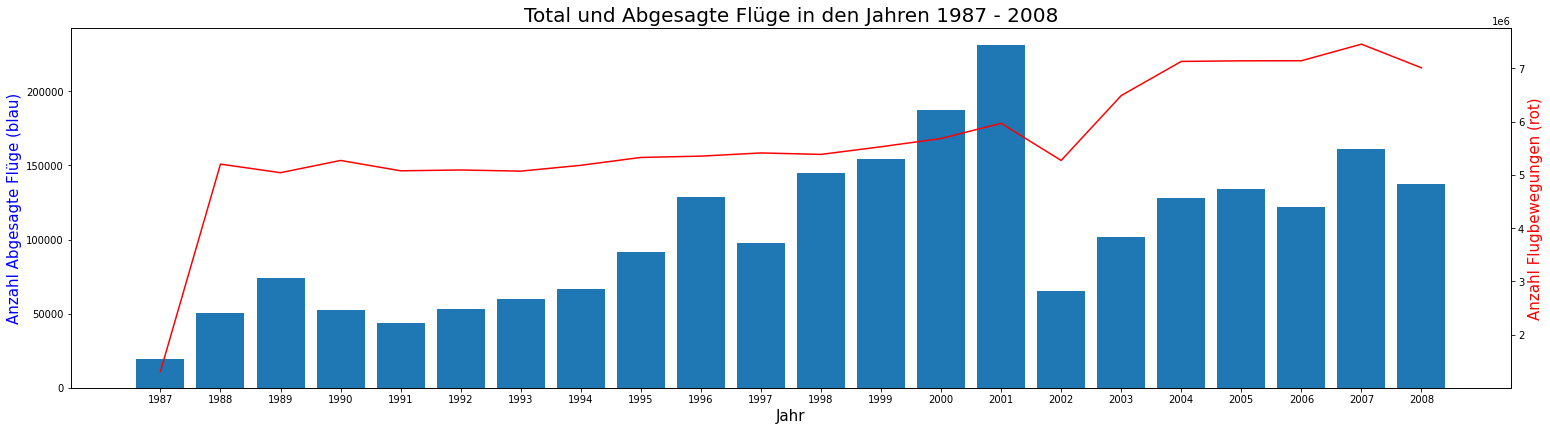

In [210]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
x=dfPlot6.toPandas()["Year"].values.tolist()
y1=dfPlot6.toPandas()["Cancelled"].values.tolist()
ax.set_title("Total und Abgesagte Flüge in den Jahren 1987 - 2008", fontsize=20)
plt.xlabel("Jahr", fontsize=15)
plt.ylabel("Anzahl Abgesagte Flüge (blau)", fontsize=15, color="b")
ax.bar(x,y1)
ax2 = plt.twinx()
ax2.set_ylabel("Anzahl Flugbewegungen (rot)", color ="r", fontsize=15)
plt.plot(dfPlot6.toPandas()["Year"], dfPlot6.toPandas()["TotalFluege"], color='red')

Die Grafik zeigt, dass die Flugbewegungen vom Jahr 2001 ins 2002 einen Einbruch von ca. 10% erlitten (roter Knick in der Grafik), Nachweis Werte unten.

In [211]:
from pyspark.sql.functions import col
flug6.filter(col("Year").rlike("2001|2002")).show()

+----+---------+-----------+
|Year|Cancelled|TotalFluege|
+----+---------+-----------+
|2001| 231198.0|    5967780|
|2002|  65143.0|    5271359|
+----+---------+-----------+



Nachfolgend prüfen wir, wie nahe diese mit dem Terroranschlag von 9/11 (am (11.09.2001) in der USA zu tun hat.

In [212]:
flug7 = spark.sql("""
SELECT CAST(Month AS integer), SUM(Cancelled) as Cancelled, COUNT(FlightNum) as TotalFluege 
FROM df_air 
WHERE Year = "2001"
GROUP BY MONTH""").orderBy("Month")

In [ ]:
dfPlot7 = flug7

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
x=dfPlot7.toPandas()["Month"].values.tolist()
y1=dfPlot7.toPandas()["Cancelled"].values.tolist()
ax.set_title('Total und Cancelled Flüge im Jahr 2001 pro Monat', fontsize=20)
plt.xlabel("Monat", fontsize=15)
plt.ylabel("Anzahl Cancelled Flüge (blau)", fontsize=15, color="b")
ax.bar(x,y1)
ax2 = plt.twinx()
ax2.set_ylabel("Total Flüge (rot)", color ="r", fontsize=15)
plt.plot(dfPlot7.toPandas()["Month"], dfPlot7.toPandas()["TotalFluege"], color='red')

In der obigen Grafik ist sehr gut ersichtlich, dass im September 2001 sehr viele Flüge gecancelled wurden und die ANzahl Flüge von vorherüber 540'000/Monat auf noch etwas über 400'000 Flüge pro Monat ausgeführt wurden.

In [205]:
flug8 = spark.sql("""
SELECT CAST(DayofMonth AS integer), SUM(Cancelled) as Cancelled, COUNT(FlightNum) as TotalFluege 
FROM df_air 
WHERE Year = "2001" AND Month = "9"
GROUP BY DayOfMonth""").orderBy("DayofMonth")

+----------+---------+-----------+
|DayofMonth|Cancelled|TotalFluege|
+----------+---------+-----------+
|         1|    196.0|      14657|
|         2|    155.0|      14365|
|         3|    158.0|      16818|
|         4|    489.0|      17714|
|         5|    324.0|      17649|
|         6|    318.0|      17648|
|         7|    594.0|      17672|
|         8|    375.0|      15697|
|         9|    300.0|      16822|
|        10|    661.0|      17566|
|        11|  14962.0|      17503|
|        12|  17535.0|      17536|
|        13|  16109.0|      17554|
|        14|   9611.0|      17356|
|        15|   5573.0|      15207|
|        16|   4297.0|      16540|
|        17|   3518.0|      17226|
|        18|   3402.0|      17201|
|        19|   2888.0|      17209|
|        20|   2946.0|      17195|
|        21|   2970.0|      17199|
|        22|   2457.0|      14888|
|        23|   1902.0|      15754|
|        24|   1515.0|      15818|
|        25|   1421.0|      15746|
|        26|   1312.

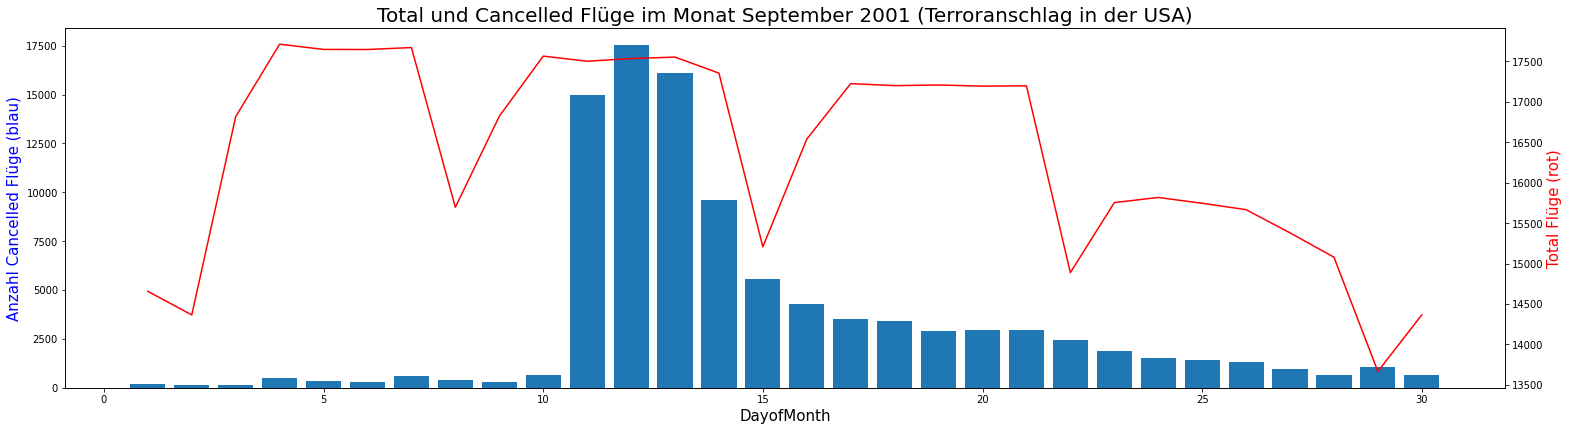

In [214]:
dfPlot8 = flug8

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
x=dfPlot8.toPandas()["DayofMonth"].values.tolist()
y1=dfPlot8.toPandas()["Cancelled"].values.tolist()
ax.set_title('Total und Cancelled Flüge im Monat September 2001 (Terroranschlag in der USA)', fontsize=20)
plt.xlabel("DayofMonth", fontsize=15)
plt.ylabel("Anzahl Cancelled Flüge (blau)", fontsize=15, color="b")
ax.bar(x,y1)
ax2 = plt.twinx()
ax2.set_ylabel("Total Flüge (rot)", color ="r", fontsize=15)
plt.plot(dfPlot8.toPandas()["DayofMonth"], dfPlot8.toPandas()["TotalFluege"], color='red')
flug8.show(31)

Der Tag des Terrors zeigt sich ganz klar in den Anzahl abgesagten Flügen ab dem 11.9.2001. In der Woche darauf waren noch in etwa gleich viele Flüge wie vorher geplant, jedoch immer noch (im Vergleich zu vor 9/11) auf sehr hohem Niveau. Und in der 2. Woche nach dem Anschlag wurden weniger Flüge geschaduled. Dies zeigt sich an der stark gesunkenen roten Linie ab dem 22.9.2001. Und da weniger Flüge geplant waren, konnten die abgesagten Flüge weiter reduziert werden.

In [12]:
spark.stop()